<a href="https://colab.research.google.com/github/AmirHesamKamalpour/Information-retrieval-system-based-on-tf-idf-using-bigrams-and-unigrams/blob/main/Information_Retrieval_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install git+https://github.com/roshan-research/hazm.git

In [ ]:
pip install python-bidi

In [ ]:
pip install --upgrade arabic-reshaper

In [ ]:
!pip install -U sentence-transformers

In [ ]:
import pandas as pd
from hazm import *
import string
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
from arabic_reshaper import reshape
from bidi.algorithm import get_display
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import ngrams
import numpy as np
from sentence_transformers import SentenceTransformer
import re

In [ ]:
df = pd.read_csv("/content/crawl-result.csv")

In [ ]:
df

,class,text
0,sport,بانوی قهرمان کشورمان با وزیر ورزش و جوانان د...
1,sport,بانوی المپیکی تیراندازی ایران گفت با کمبود...
2,sport,با اعلام شکایت مجدد مسئولان تنیس استونی از م...
3,sport,سرمربی تیم ملی فوتبال ایران با تاکید بر این...
4,sport,هواداران تیم فوتبال بارسلونا در نیمه‌نهایی س...
...,...,...
1114,art,ویلای ساحلی چقدر به معیارهای خود کیانوش عیار...
1115,art,اسامی ۶ تن از ستارگان هالیوود در فهرست افشایی ...
1116,art,۶ مستندی که در اینجا معرفی کرده‌ایم داستان‌های...
1117,art,تصویربرداری سریال گناه فرشته به نویسندگی و ک...


In [ ]:
df = df.rename(columns={'Category': 'class', 'Description': 'text'})

In [ ]:
df.head()

,class,text
0,sport,تهران- ایرنا- بانوی قهرمان کشورمان با وزیر ورز...
1,sport,تهران - ایرنا- بانوی المپیکی تیراندازی ایران، ...
2,sport,تهران- ایرنا- با اعلام شکایت مجدد مسئولان تنیس...
3,sport,تهران - ایرنا - سرمربی تیم ملی فوتبال ایران با...
4,sport,تهران - ایرنا- هواداران تیم فوتبال بارسلونا در...


In [ ]:
df_classes = df.groupby(['class']) # detect duplicates
df_classes.describe()

text                                                               
          count unique                                                top freq
class                                                                         
art         176    176  تهران- ایرنا- برج میلاد به عنوان خانه جشنواره ...    1
economy     300    275  تهران- ایرنا- آموزش‌های مهارتی در دولت سیزدهم ...    2
political   313    272  تهران- ایرنا- فرمانده سپاه در دوران دفاع مقدس ...    3
sport       330    277  تهران- ایرنا- بانوی قهرمان کشورمان با وزیر ورز...    2

We can safely use the original `**semi-spaces**` without any issues. The display of `**"\u200c"**` is specific to the output rendering in Colab and **`does not affect the underlying data itself`**.

In [ ]:
df['text'][56]

'گرگان- ایرنا- رییس فدراسیون شمشیربازی با بیان اینکه پشتوانه\u200cسازی برای تیم\u200cهای ملی بزرگسالان اولویت اصلی فدراسیون است گفت: برگزاری اردوهای مشترک نوجوانان با جوانان و بزرگسالان در دستور کار قرار دارد.'

In [ ]:
def vectorize_sentences(dataset, column, model_name='sentence-transformers/LaBSE'):

    df = dataset.copy()

    model = SentenceTransformer(model_name)

    def encode_sentence(sentence):
        return model.encode([sentence])[0]

    df['Vector'] = df[column].apply(encode_sentence)

    return df

In [ ]:
def calculate_tfidf(dataset, column, n = 1):

    tokenizer = WordTokenizer()
    tf_idf = {}
    N = dataset.shape[0]
    tokens_column = dataset[column].apply(tokenizer.tokenize)

    if n == 2:
      tokens_column = tokens_column.apply(lambda tokens: list(ngrams(tokens, n)))

    for index, tokens in tokens_column.iteritems():
        counter = Counter(tokens)
        words_count = len(tokens)
        unique_tokens = set(tokens)

        for token in unique_tokens:
            tf = counter[token] / words_count

            if n == 2:
              df = dic2.get(token, 0)
            else:
              df = dic.get(token, 0)

            idf = np.log((N + 1) / (df + 1))

            tf_idf[index, token] = tf * idf

    return tf_idf

In [ ]:
def vectorize_query(query, terms, tfidf_matrix_shape, n = 1):

    tokenizer = WordTokenizer()
    tokens = tokenizer.tokenize(query)
    tfidf_vector = np.zeros(len(terms))

    if n == 2:
      tokens = list(ngrams(tokens, n))

    counter = Counter(tokens)
    words_count = len(tokens)

    for token in set(tokens):
        tf = counter[token] / words_count
        if n==2:
          df = dic2.get(token, 0)
        else:
          df = dic.get(token, 0)
        idf = np.log((tfidf_matrix_shape[0] + 1) / (df + 1))

        if token in terms:
            term_idx = terms.index(token)
            tfidf_vector[term_idx] = tf * idf

    return tfidf_vector

In [ ]:
def cosine_similarity(vector1, vector2):
  dot_product = np.einsum('i,i', vector1, vector2)
  norm1 = np.linalg.norm(vector1)
  norm2 = np.linalg.norm(vector2)
  return dot_product / (norm1 * norm2) if norm1 * norm2 != 0 else 0

In [ ]:
def compute_cosine_similarity_query(query_vector, tfidf_matrix):

    similarity_scores = []

    for i in range(tfidf_matrix.shape[0]):
        similarity_scores.append(cosine_similarity(query_vector, tfidf_matrix[i]))

    return similarity_scores

In [ ]:
def get_top_similar_results(N_closest, query_similarity_scores, output_file):

    top_similar_indices = sorted(range(len(query_similarity_scores)), key=lambda i: query_similarity_scores[i], reverse=True)[:N_closest]
    top_similar_scores = sorted(query_similarity_scores, reverse=True)[:N_closest]

    result_df = pd.DataFrame({'Document_Index': top_similar_indices, 'Similarity_Score': top_similar_scores})

    result_df.to_csv(output_file, index=False)

    return result_df

In [ ]:
def jaccard_coefficient(query_tokens, doc_tokens, n) -> float:

  union_of_words = set(doc_tokens).union(set(query_tokens))
  union_length = len(union_of_words)

  intersection_of_sentences = len(set(query_tokens)) + len(set(doc_tokens)) - union_length

  return intersection_of_sentences / union_length

In [ ]:
def compute_jaccard_coefficient_similarity_query(query, dataset, n = 1):

  tokenizer = WordTokenizer()
  query_tokens = set(tokenizer.tokenize(query))
  similarity_scores = []
  if n == 2:
    query_tokens = list(ngrams(query_tokens, 2))

  for _, row in dataset.iterrows():
    doc_tokens = set(tokenizer.tokenize(row['text']))
    if n == 2:
      doc_tokens = list(ngrams(doc_tokens, 2))
    similarity_scores.append(jaccard_coefficient(query_tokens, doc_tokens, n))

  return similarity_scores

# Preprocessing Dataset

In [ ]:
def plot_most_repeated_words(sorted_dict, number):

  words = list(sorted_dict.keys())[:number]
  counts = list(sorted_dict.values())[:number]

  persian_words = [get_display(reshape(word)) for word in words]

  plt.figure(figsize=(10, 6))
  plt.bar(persian_words, counts)
  plt.xticks(rotation=90)
  plt.xlabel('Words')
  plt.ylabel('Counts')
  plt.title(f'Top {number} Words')
  plt.tight_layout()
  plt.show()

In [ ]:
def build_vocabulary_dataset(dataset, column: string) -> dict :

  all_text = ' '.join(dataset[column].astype(str))
  tokenizer = WordTokenizer()
  words = tokenizer.tokenize(all_text)
  word_counts = Counter(words)
  word_counts_dict = dict(word_counts)

  with open('vocabulary.txt', 'w') as file:
    for word, count in word_counts.items():
        file.write(f"{word}: {count} times\n")

  return word_counts_dict

In [ ]:
def build_bigram_vocabulary_dataset(dataset, column):

    all_text = ' '.join(dataset[column].astype(str))
    tokenizer = WordTokenizer()
    tokens = tokenizer.tokenize(all_text)
    bigrams = list(ngrams(tokens, 2))

    word_counts = Counter(bigrams)
    word_counts_dict = dict(word_counts)

    with open('vocabulary_bigram.txt', 'w') as file:
        for word, count in word_counts.items():
            file.write(f"{word}: {count} times\n")

    return word_counts_dict

In [ ]:
def remove_stop_words_dataset(dataset, column: string):

  stop_words = stopwords_list()
  pat = r'\b(?:{})\b'.format('|'.join(stop_words))
  dataset[column] = dataset[column].str.replace(pat, '')
  dataset[column] = dataset[column].str.replace(r'\s+', ' ')

  return dataset

In [ ]:
def remove_stop_words_query(query):

  stop_words = stopwords_list()
  new_query = ' '.join([word for word in query.split() if word not in stop_words])

  return new_query

In [ ]:
def preprocess_dataset(dataframe, column: str, normalization : bool = True, stopword_removal: bool = True, stemming: bool = True):

  processed_df = dataframe.copy()
  normalizer = Normalizer()
  stemmer = Stemmer()

  if normalization is True:
    processed_df[column] = processed_df[column].apply(normalizer.normalize)

  if stopword_removal is True:
    processed_df = remove_stop_words_dataset(processed_df, column)

  if stemming is True:
    processed_df[column] = processed_df[column].apply(stemmer.stem)


  processed_df.drop_duplicates(subset=[column], keep= 'first', inplace = True)

  return processed_df.reset_index(drop = True)

In [ ]:
def preprocess_query(query, normalization : bool = True, stopword_removal: bool = True, stemming: bool = True):

  normalizer = Normalizer()
  stemmer = Stemmer()

  if normalization is True:
    query = normalizer.normalize(query)

  if stopword_removal is True:
    query = remove_stop_words_query(query)

  if stemming is True:
    query = stemmer.stem(query)

  return query

In [ ]:
to_replace = ['-', '.', '،', ':', '«', '»', '(', ')', '؛',"!", '?', '؟']
for substring in to_replace:
    df['text'] = df['text'].str.replace(substring, ' ')
df['text'] = df['text'].apply(lambda x: re.sub(r'.*ایرنا\b', '', x))
processed_df = preprocess_dataset(df, 'text')

In [ ]:
processed_df

,class,text
0,sport,بانوی قهرمان کشورمان وزیر ورزش جوانان محل سفار...
1,sport,بانوی المپیکی تیراندازی ایران کمبودهایی داشتیم...
2,sport,اعلام شکایت مجدد مسئولان تنیس استونی میزبانی ...
3,sport,سرمربی تیم ملی فوتبال ایران تاکید شاهد جام‌ملت...
4,sport,هواداران تیم فوتبال بارسلونا ‌نهایی سوپرکاپ اس...
...,...,...
988,art,ویلای ساحلی چقدر معیارهای کیانوش عیاری عنوان ف...
989,art,اسامی ۶ تن ستارگان هالیوود فهرست افشایی جزیره ...
990,art,۶ مستندی معرفی ‌ایم داستان‌ هیجان‌انگیز دل واق...
991,art,تصویربرداری سریال گناه فرشته نویسندگی کارگردان...


In [ ]:
df_classes = processed_df.groupby(['class']) # detect duplicates --> no duplication is seen
df_classes.describe()

text                                                               
          count unique                                                top freq
class                                                                         
art         176    176  برج میلاد عنوان خانه جشنواره فجر چهل دومین دور...    1
economy     271    271  آموزش‌های مهارتی دولت سیزدهم دولتی غیردولتی ۲ ...    1
political   272    272  رئیس مجمع نمایندگان استان تهران مجلس بچه‌های ح...    1
sport       274    274  بانوی قهرمان کشورمان وزیر ورزش جوانان محل سفار...    1

In [ ]:
dic = build_vocabulary_dataset(processed_df, 'text')
dic2 = build_bigram_vocabulary_dataset(processed_df, 'text')

In [ ]:
sorted_dict = dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))
sorted_dict2 = dict(sorted(dic2.items(), key=lambda item: item[1], reverse=True))

In [ ]:
sorted_dict

{'ایران': 218,
 '\u200c': 164,
 'ملی': 139,
 'تیم': 138,
 'کشور': 125,
 'اسلامی': 95,
 'حضور': 88,
 'سال': 86,
 'اعلام': 84,
 'دولت': 82,
 'هزار': 80,
 'قیمت': 77,
 'سازمان': 75,
 'امروز': 66,
 'وزیر': 65,
 'رئیس': 63,
 'مجلس': 63,
 'مردم': 60,
 'تهران': 59,
 'تومان': 59,
 'افزایش': 58,
 'شورای': 57,
 'فوتبال': 56,
 'روز': 56,
 'وزارت': 56,
 'گذشته': 54,
 'فدراسیون': 51,
 'آسیا': 51,
 'درصد': 51,
 'فیلم': 49,
 'برگزار': 48,
 'کرمان': 48,
 'قرار': 46,
 'کاهش': 46,
 'خبر': 45,
 'معاون': 45,
 'میلیون': 45,
 'انقلاب': 44,
 'جشنواره': 42,
 'دلار': 40,
 'جهان': 39,
 'مرکز': 39,
 '۲': 38,
 'عنوان': 38,
 'امور': 38,
 'سرمربی': 37,
 'رییس': 37,
 'اقتصادی': 37,
 'موسیقی': 37,
 'پایان': 35,
 'والیبال': 35,
 'انجام': 35,
 'نمایش': 35,
 'منتشر': 34,
 'لیگ': 34,
 'مسابقات': 33,
 'عضو': 33,
 'رهبر': 33,
 'ارز': 32,
 'دی\u200cماه': 31,
 'توسعه': 31,
 'کار': 31,
 'اطلاعات': 31,
 'بازار': 31,
 'برنامه': 30,
 'تروریستی': 30,
 'میلیارد': 30,
 'ورزش': 29,
 'جهانی': 29,
 'جام': 29,
 'هفته': 29,
 'طلا': 29,


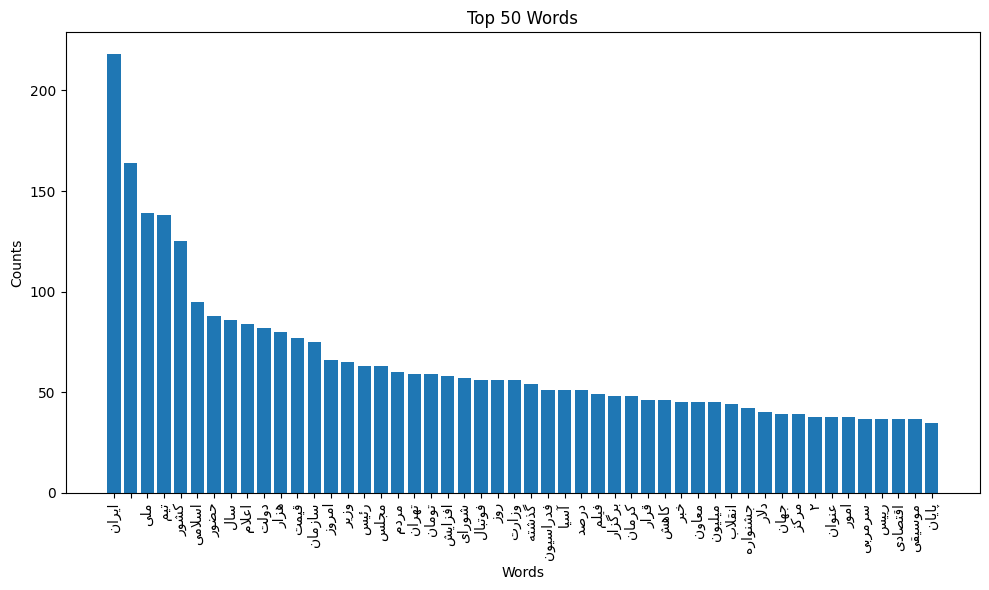

In [ ]:
plot_most_repeated_words(sorted_dict, 50)

based on unigram

In [ ]:
tfidf_values = calculate_tfidf(processed_df, 'text', 1)
terms = sorted(list(set([key[1] for key in tfidf_values.keys()])))
tfidf_matrix = np.zeros((processed_df.shape[0], len(terms)))

for (doc_idx, term), value in tfidf_values.items():
    term_idx = terms.index(term)
    tfidf_matrix[doc_idx, term_idx] = value

<ipython-input-12-4db846866a35>:11: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, tokens in tokens_column.iteritems():


In [ ]:
np.unique(tfidf_matrix)

array([0.        , 0.03602684, 0.03879813, ..., 1.03560127, 1.08063158,
       1.27874883])

In [ ]:
processed_df['text'][49]

'رییس فدراسیون شمشیربازی پشتوانه\u200c تیم\u200cهای ملی بزرگسالان اولویت اصلی فدراسیون برگزاری اردوهای مشترک نوجوانان جوانان بزرگسالان دستور کار قرار '

In [ ]:
df['text'][56]

'  رییس فدراسیون شمشیربازی با بیان اینکه پشتوانه\u200cسازی برای تیم\u200cهای ملی بزرگسالان اولویت اصلی فدراسیون است گفت  برگزاری اردوهای مشترک نوجوانان با جوانان و بزرگسالان در دستور کار قرار دارد '

In [ ]:
processed_df['text'][390]

'اداره امور مالیاتی استان البرز شناسایی فرار مالیاتی ارزش ۵۰۰ میلیارد تومان خبر '

In [ ]:
query_text = 'برگزاری اردوهای مشترک نوجوانان با جوانان و بزرگسالان'
query_vector = vectorize_query(preprocess_query(query_text), terms, tfidf_matrix.shape, 1)
query_similarity_scores = compute_cosine_similarity_query(query_vector, tfidf_matrix)
get_top_similar_results(10, query_similarity_scores, "Unigram_Results.csv")

,Document_Index,Similarity_Score
0,49,0.536265
1,569,0.328363
2,271,0.208917
3,93,0.139614
4,473,0.116478
5,189,0.108817
6,143,0.098003
7,34,0.094925
8,38,0.091010
9,140,0.087226


based on bigrams

In [ ]:
tfidf_values = calculate_tfidf(processed_df, 'text', 2)
terms = sorted(list(set([key[1] for key in tfidf_values.keys()])))
tfidf_matrix = np.zeros((processed_df.shape[0], len(terms)))

for (doc_idx, term), value in tfidf_values.items():
    term_idx = terms.index(term)
    tfidf_matrix[doc_idx, term_idx] = value

<ipython-input-12-4db846866a35>:11: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, tokens in tokens_column.iteritems():


In [ ]:
query_text = 'برگزاری اردوهای مشترک نوجوانان با جوانان و بزرگسالان'
query_vector = vectorize_query(preprocess_query(query_text), terms, tfidf_matrix.shape, 2)
query_similarity_scores = compute_cosine_similarity_query(query_vector, tfidf_matrix)
get_top_similar_results(10, query_similarity_scores, 'Bigram_Results.csv')

,Document_Index,Similarity_Score
0,49,0.494344
1,0,0.000000
2,1,0.000000
3,2,0.000000
4,3,0.000000
5,4,0.000000
6,5,0.000000
7,6,0.000000
8,7,0.000000
9,8,0.000000


based on Mr.Jaccard

In [ ]:
jaccard_similarity = compute_jaccard_coefficient_similarity_query(preprocess_query(query_text), processed_df, 1)
get_top_similar_results(5, jaccard_similarity,'Jaccard_Results.csv')

,Document_Index,Similarity_Score
0,49,0.277778
1,569,0.176471
2,271,0.111111
3,38,0.076923
4,45,0.066667


In [ ]:
jaccard_similarity = compute_jaccard_coefficient_similarity_query(preprocess_query(query_text), processed_df, 2)
get_top_similar_results(5, jaccard_similarity,'Jaccard_Bigram_Results.csv')

,Document_Index,Similarity_Score
0,49,0.105263
1,569,0.058824
2,0,0.000000
3,1,0.000000
4,2,0.000000
